Optimisation du modèle XGBoost et de ses features

Librairies

In [1]:
import math
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import to_graphviz
from xgboost import plot_tree
from xgboost import plot_importance
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import Booster

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit

'ok'

'ok'

In [2]:
#On charge les données

dataframe = pd.read_csv('Data\BDDLASTQUART.csv', engine='python', )
dataset = dataframe.values

#On donne ce que l'on doit trouver (y) et avec quoi (X)

X = dataframe.drop('Vente', axis=1)
y = dataframe['Vente']
#On définit la MAPE qui sert quantifier l'erreur: pourcentage moyen de différence

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)   
    a = np.array(y_true)
    b = np.array(y_pred)
    mean = (a + b)/2.0
    return 100*np.mean(np.abs((y_true - y_pred) / np.maximum(mean, 1)))

#On définit la RMSE qui sert quantifier l'erreur: valeur moyenne de différence

def root_mean_square_error(y_pred, y_true):
    return math.sqrt(mean_squared_error(y_pred, y_true))

'ok'

'ok'

Cross Validation

In [3]:
#Création des splits différents

# X_groups = pd.qcut(X.index, 100, labels=False)
pred = pd.Series([np.nan] * len(X), index=X.index)

n_predictions = 4
periode_prediction = 30

tss = TimeSeriesSplit(n_splits=n_predictions)
m_err=0
for train_index, test_index in tss.split(X): #, groups=X_groups):
    test_index = test_index[0:periode_prediction]
    
    X_train = X.loc[train_index]
    y_train = y.loc[train_index]
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]
    
    #Entrainement du modèle
    
    model=XGBRegressor()
    model.fit(X_train, y_train)

    #récupération des valeurs préditent
    
    pred.loc[test_index] = model.predict(X_test)

#Calcul des erreurs
    
predicted_index = ~pred.isnull()
relative_error = mean_absolute_error(y[predicted_index], pred[predicted_index]) / np.mean(y)
mape=mean_absolute_percentage_error(y[predicted_index], pred[predicted_index])
print('Relative error for model {}: {:.2f}% '.format(model.__class__.__name__, relative_error*100))
print('Relative MAPE error for model: {:.2f}% '.format(mape))

Relative error for model XGBRegressor: 16.18% 
Relative MAPE error for model: 20.29% 


In [4]:
#Sortie des features importantes à l'aide d'arbre

regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X, y)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
cols = pd.DataFrame(regr.feature_importances_, index=X.columns)
cols[cols[0]>0]*100

,0
H_8.0,55.277562
H_21.0,42.278421
Q_45.0,2.444017


Split "taille" pour tester le modèle

In [5]:
#80 de valeur train et 20 de test

taille=len(X)*0.80

#Création de toutes les variables

X_train = X[dataframe.index < taille]
y_train = y[dataframe.index < taille]

X_test = X[dataframe.index >= taille]
y_test = y[dataframe.index >= taille]

#Entrainement du modèle

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)

#Calcul des erreurs

error = None
mape = mean_absolute_percentage_error(y_test, predictions)
rmse = root_mean_square_error(y_test, predictions)
print('Relative MAPE error for model: {:.2f}% '.format(mape))
print('Relative RMSE error for model: {:.2f} '.format(rmse))

Relative MAPE error for model: 25.27% 
Relative RMSE error for model: 53.26 


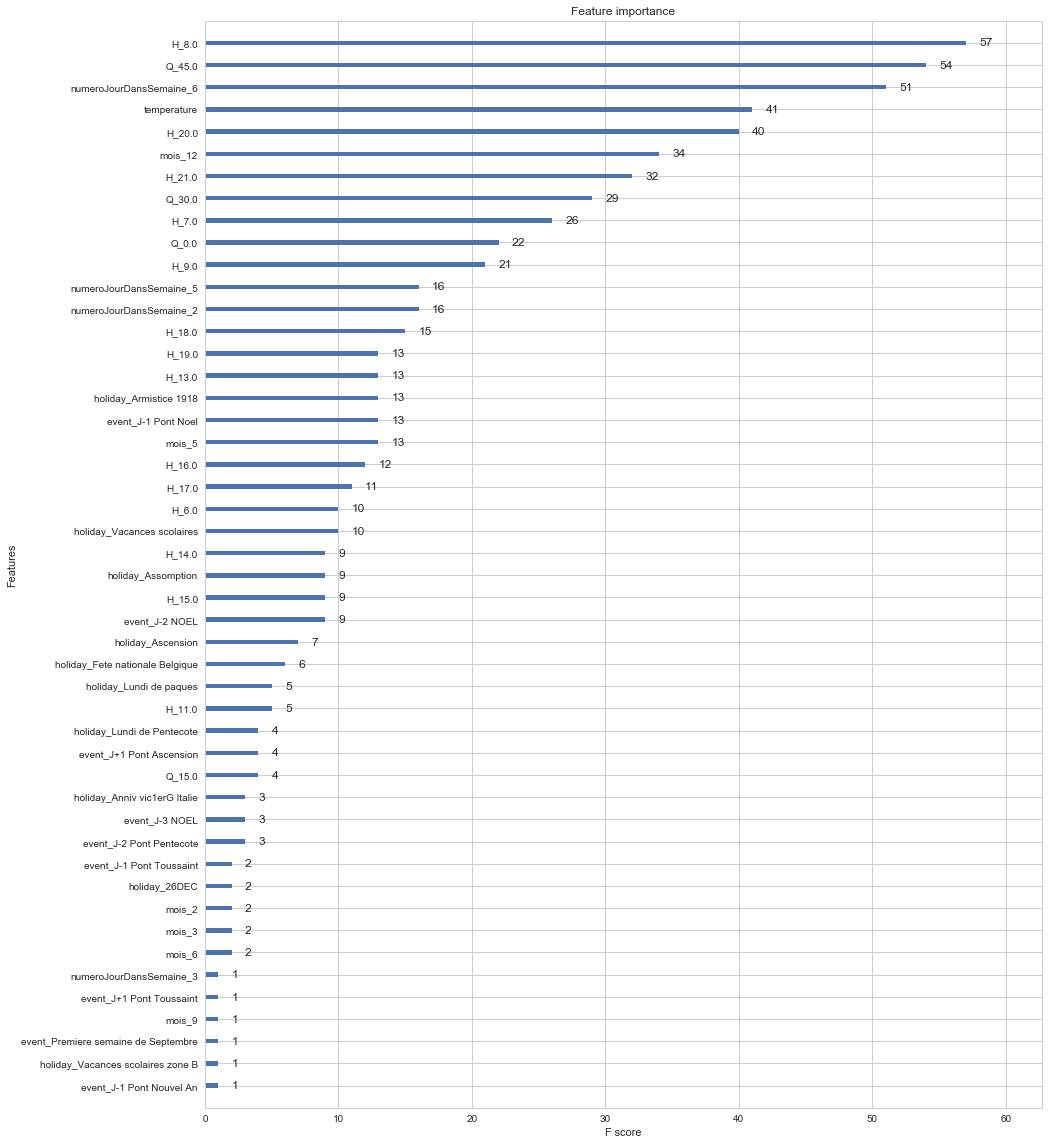

In [6]:
#Affichage de l'importance des features

sns.set(rc={"figure.figsize": (15, 20)})
sns.set_style("whitegrid")
plot_importance(xgb)
plt.show()

In [7]:
#Regroupement des features

mois=['mois_1','mois_2','mois_3','mois_4','mois_5','mois_6',
      'mois_7','mois_8','mois_9','mois_10','mois_11','mois_12']

numeroJourDansSemaine=['numeroJourDansSemaine_1','numeroJourDansSemaine_2',
                       'numeroJourDansSemaine_3','numeroJourDansSemaine_4',
                       'numeroJourDansSemaine_5','numeroJourDansSemaine_6']

holiday = ['holiday_26DEC', 'holiday_Anniv vic1erG Italie',
       'holiday_Armistice 1918', 'holiday_Ascension', 'holiday_Assomption',
       'holiday_Epiphanie Espagne', 'holiday_Fete constitution Espagne',
       'holiday_Fete nationale', 'holiday_Fete nationale Belgique',
       'holiday_Fete nationale Espagne', 'holiday_Fete nationale Luxembourg',
       'holiday_Fete nationale Suisse', 'holiday_Immac Concep',
       'holiday_Jour unite nationale Allemagne', 'holiday_Lundi de Pentecote',
       'holiday_Lundi de paques', 'holiday_Rosenmontag', 'holiday_Toussaint',
       'holiday_Vacances scolaires', 'holiday_Vacances scolaires zone B',
       'holiday_Victoire 1945', 'holiday_vendredi saint']

event = ['event_Aid El Fitr', 'event_Aid El Kebir',
       'event_Allocation impactante', 'event_Beaujolais nouveau',
       'event_Chandeleur', 'event_Fete de la musique',
       'event_J+1 FETES DES MERES', 'event_J+1 FETES DES PERES',
       'event_J+1 Pont 11 novembre', 'event_J+1 Pont 14 juillet',
       'event_J+1 Pont 15 aout', 'event_J+1 Pont 1er mai',
       'event_J+1 Pont 8 mai', 'event_J+1 Pont Ascension',
       'event_J+1 Pont Nouvel An', 'event_J+1 Pont Pentecote',
       'event_J+1 Pont Toussaint', 'event_J+1 Pont paques',
       'event_J+2 EPIPHANIE', 'event_J+2 FETES DES PERES',
       'event_J+2 Pont 11 novembre', 'event_J+2 Pont 14 juillet',
       'event_J+2 Pont 15 aout', 'event_J+2 Pont 1er mai',
       'event_J+2 Pont 8 mai', 'event_J+2 Pont Ascension',
       'event_J+2 Pont Noel', 'event_J+2 Pont Nouvel An',
       'event_J+2 Pont Pentecote', 'event_J+2 Pont Toussaint',
       'event_J+2 Pont paques', 'event_J-1 BEAUJOLAIS NOUVEAU',
       'event_J-1 Pont 11 novembre', 'event_J-1 Pont 14 juillet',
       'event_J-1 Pont 15 aout', 'event_J-1 Pont 1er mai',
       'event_J-1 Pont 8 mai', 'event_J-1 Pont Ascension',
       'event_J-1 Pont Noel', 'event_J-1 Pont Nouvel An',
       'event_J-1 Pont Toussaint', 'event_J-1 Vendredi Saint',
       'event_J-2 NOEL', 'event_J-2 Nouvel An', 'event_J-2 Pont 11 novembre',
       'event_J-2 Pont 14 juillet', 'event_J-2 Pont 15 aout',
       'event_J-2 Pont 1er mai', 'event_J-2 Pont 8 mai',
       'event_J-2 Pont Ascension', 'event_J-2 Pont Pentecote',
       'event_J-2 Pont paques', 'event_J-3 NOEL', 'event_J-3 Nouvel An',
       'event_J-3 VENDREDI PENTECOTE', 'event_J-4 NOEL',
       'event_Lundi Juillet Aout', 'event_Mardi Aout', 'event_Mardi-Gras',
       'event_Nouvel an chinois', 'event_Premiere semaine de Septembre',
       'event_Ramadan', 'event_Saint-Nicolas', 'event_Saint-Valentin',
       'event_Samedi Aout sauf dernier']

temperature= ['temperature']

prixVente=['prixVente']

promo=['promo']

H=['H_6.0', 'H_7.0', 'H_8.0', 'H_9.0', 'H_10.0', 'H_11.0', 'H_12.0',
       'H_13.0', 'H_14.0', 'H_15.0', 'H_16.0', 'H_17.0', 'H_18.0', 'H_19.0',
       'H_20.0', 'H_21.0', 'H_22.0']

Q=['Q_0.0', 'Q_15.0', 'Q_30.0', 'Q_45.0']

Vente=['Vente']

features=mois+numeroJourDansSemaine+event+holiday+temperature+prixVente+promo+H+Q+Vente#+temperature

'ok'

'ok'

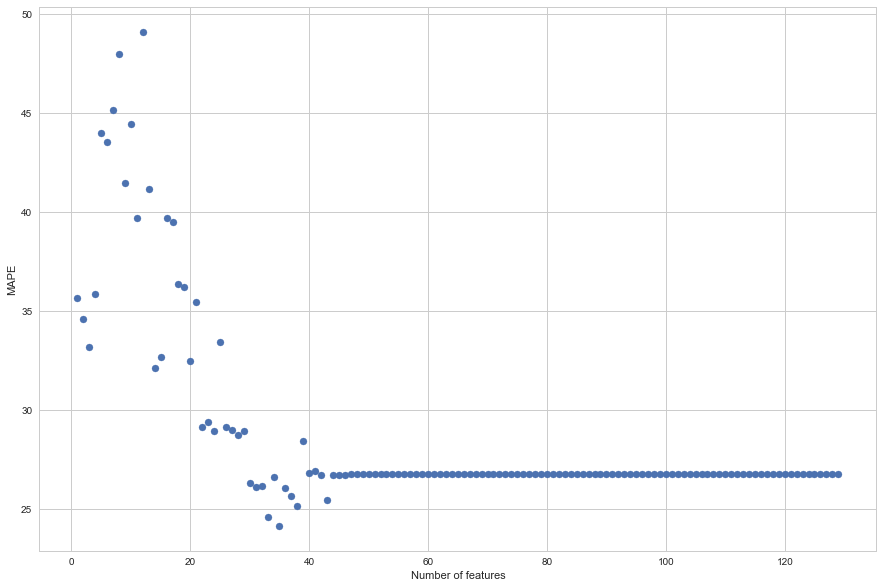

In [8]:
#Metrique à traiter

metric = "MAPE"

#Trie des features par importance

post_xgb_features = xgb.get_booster().get_fscore()

sorted_post_xgb_features = sorted(post_xgb_features.items(), key = lambda x: x[1], reverse = True)

xgb_features = [feature for (feature, score) in sorted_post_xgb_features]

other_features = [feature for feature in features if feature not in xgb_features]

all_features_sorted = xgb_features + other_features

#Gestion data/features

def get_error_with_n_best_features(features, n, X_train, X_test, y_train, y_test, metric):
    best_features = features[0:n]

    X_train = X_train[best_features]
    X_test = X_test[best_features]
    
    xgb = XGBRegressor()
    xgb.fit(X_train, y_train)
    predictions = xgb.predict(X_test)
    
    if metric == "RMSE":
        return root_mean_square_error(y_test, predictions)
    elif metric == "MAPE":
        return mean_absolute_percentage_error(y_test, predictions)
    else:
        raise Error("No metric known specified")

#Affichage du meilleure taux selon le nombre de features
        
x = range(1, len(all_features_sorted))
result = [get_error_with_n_best_features(all_features_sorted, i, X_train, X_test, y_train, y_test, metric) for i in x]
sns.set(rc={"figure.figsize": (15,10)})
sns.set(style="whitegrid")
plt.xlabel("Number of features")
plt.ylabel(metric)
plt.scatter(x, result)
plt.show()

Traitement des paramètres optimaux selon les features

In [9]:
#Nombre de features optimal

n_best_features = np.argmin(result)

print ("The optimal number of features to use is %d" % (n_best_features + 1))

best_features = all_features_sorted[0:n_best_features+1]
#print(best_features)

#Données selon les features

X_train = X_train[best_features]
X_test = X_test[best_features]

#Entrainement selon différent paramètre 

model = XGBRegressor(eval_metrics='mape')
param_dict = {
    'nthread':[1], 
    'learning_rate': [0.05], 
    'max_depth': [3, 6],
    'min_child_weight': [1],
    'n_estimators': [200],
    'seed': [2],
    'subsample': [1]
}

#Fonction pour trouver les paramètres optimaux

cv = GridSearchCV(model, param_dict, n_jobs=5)
cv.fit(X_train, y_train)
params = cv.best_params_
params

The optimal number of features to use is 35


{'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 200,
 'nthread': 1,
 'seed': 2,
 'subsample': 1}

In [10]:

#Entrainement avec les meilleurs paramètres

xgb = XGBRegressor(**params)
xgb.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = False)
predictions = xgb.predict(X_test)

#Calcul de l'erreur minimale

error = None
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
rmse = root_mean_square_error(y_test, predictions)
print('Relative MAPE error for model: {:.2f}% '.format(mape))
print('Relative RMSE error for model: {:.2f} '.format(rmse))
print('Relative MAE error for model: {:.2f} '.format(mae))

Relative MAPE error for model: 25.27% 
Relative RMSE error for model: 52.28 
Relative MAE error for model: 38.40 


In [11]:
#print(best_features)

['H_8.0', 'Q_45.0', 'numeroJourDansSemaine_6', 'temperature', 'H_20.0', 'mois_12', 'H_21.0', 'Q_30.0', 'H_7.0', 'Q_0.0', 'H_9.0', 'numeroJourDansSemaine_2', 'numeroJourDansSemaine_5', 'H_18.0', 'mois_5', 'event_J-1 Pont Noel', 'holiday_Armistice 1918', 'H_13.0', 'H_19.0', 'H_16.0', 'H_17.0', 'holiday_Vacances scolaires', 'H_6.0', 'event_J-2 NOEL', 'H_15.0', 'holiday_Assomption', 'H_14.0', 'holiday_Ascension', 'holiday_Fete nationale Belgique', 'H_11.0', 'holiday_Lundi de paques', 'Q_15.0', 'event_J+1 Pont Ascension', 'holiday_Lundi de Pentecote', 'event_J-2 Pont Pentecote']
